In [2]:
from xgboost import XGBRegressor

import sys
if '..' not in sys.path:
    sys.path.append('..')

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

import utils

In [4]:
IMG_ID = 286 # 286 # 792 #  # 323, 119
FEAT_ROOT = '../runs/blf-resnet18-lr0.00002-bs-32-neg-5-ps-160-shift-32/'
# '../runs/blf-resnet18-lr0.00002-bs-32-neg-5/'
img = utils.load_image(Path('../data/Train/{}.jpg'.format(IMG_ID)), cache=False)
pred = np.load('{}/{}-pred.npy'.format(FEAT_ROOT, IMG_ID))
img.shape, pred.shape

((3744, 5616, 3), (6, 113, 172))

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(img);

In [ ]:
y, x = 3525, 790
patch = img[y: y + 96, x: x + 96]
plt.imshow(patch);

In [28]:
import cnn_baseline
import torchvision.models
import torch.nn

model = torchvision.models.resnet18(num_classes=utils.N_CLASSES + 1)
model.avgpool = torch.nn.AvgPool2d(96 // 32, stride=1)
model = utils.cuda(model)
cnn_baseline.load_best_model(model, Path(FEAT_ROOT))

Loaded model from epoch 99, step 245,000


In [33]:
from torch.nn import functional as F

inputs = cnn_baseline.img_transform(patch)
inputs = inputs.unsqueeze(0)
outputs = F.softmax(model(utils.variable(inputs, volatile=True)))
outputs

Variable containing:
 0.0018  0.0016  0.0059  0.0046  0.0017  0.9844
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]

In [ ]:
size = (500, 350)
small_img = cv2.resize(img, size)
pred_sum = pred[:utils.N_CLASSES].sum(axis=0)

#"""
for cls in range(utils.N_CLASSES):
    #plt.figure(figsize=(12, 10))
    plt.imshow(small_img)
    plt.imshow(cv2.resize(pred[cls], size), alpha=0.5)
    plt.show()
#"""

plt.figure(figsize=(12, 10))
plt.imshow(small_img)
plt.imshow(cv2.resize(pred_sum, size), alpha=0.7)
plt.show()

In [5]:
all_coords = utils.load_coords()

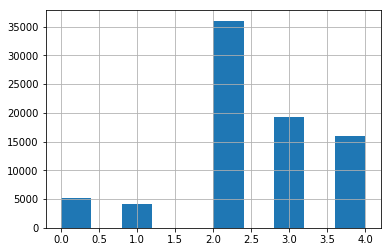

In [55]:
all_coords.cls.hist()

In [25]:
def load_features(cls):
    xs = []
    ys = []
    for pred_path in Path(FEAT_ROOT).glob('*-pred.npy'):
        img_id = int(pred_path.name.split('-')[0])
        try:
            ys.append(
                (all_coords.loc[img_id].cls == cls).sum())
        except KeyError:
            ys.append(0)
        cls_pred = np.load(str(pred_path))[cls]
        x = []
        thresholds = [0.05, 0.25, 0.45]
        for i, threshold in enumerate(thresholds):
            bin_mask = cls_pred > threshold
            if i + 1 < len(thresholds):
                bin_mask &= cls_pred < thresholds[i + 1]
            x.append(bin_mask.sum())
        # x.append(cls_pred.sum())
        xs.append(x)
        # print(img_id, ys[-1], x)

    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

all_xs, all_ys = [], []
for cls in range(utils.N_CLASSES):
    xs, ys = load_features(cls)
    all_xs.append(xs)
    all_ys.append(ys)
    # break

In [43]:
for cls in range(utils.N_CLASSES):
    print(all_xs[cls][:, 1].mean())

2.02105263158
0.0
22.8842105263
10.4105263158
309.336842105


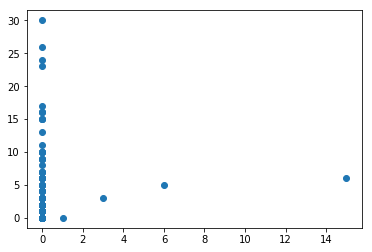

In [12]:
plt.scatter(all_xs[0][:, 0], all_ys[0])

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from IPython.core.display import display
from eli5 import show_weights
from sklearn.dummy import DummyRegressor

all_rmse = []
for cls in range(utils.N_CLASSES):
    reg = Lasso(alpha=1.0, normalize=True, max_iter=10000)
    # reg = XGBRegressor(n_estimators=20, max_depth=2)
    # reg = DummyRegressor()
    xs, ys = all_xs[cls], all_ys[cls]
    rmse = np.sqrt(-cross_val_score(reg, xs, ys, scoring='neg_mean_squared_error', cv=3))
    print('cls {}, target mean {:.2f}, RMSE {:.2f} +- {:.2f}'.format(
        cls, np.mean(ys), np.mean(rmse), 2 * np.std(rmse)))
    all_rmse.append(np.mean(rmse))
    # reg.fit(xs, ys)
    # display(show_weights(reg, target_names=['cls-{}'.format(cls)]))
print('Average RMSE: {:.2f}'.format(np.mean(all_rmse)))

cls 0, target mean 5.46, RMSE 6.03 +- 2.87
cls 1, target mean 3.97, RMSE 5.82 +- 3.08
cls 2, target mean 32.66, RMSE 57.27 +- 30.90
cls 3, target mean 16.22, RMSE 21.25 +- 5.76
cls 4, target mean 12.73, RMSE 30.26 +- 13.55
Average RMSE: 24.13


In [152]:
stacked_xs = np.concatenate(all_xs, axis=1)

all_rmse = []
for cls in range(utils.N_CLASSES):
    reg = Lasso(normalize=True)
    ys = all_ys[cls]
    xs = stacked_xs
    rmse = np.sqrt(-cross_val_score(reg, xs, ys, scoring='neg_mean_squared_error', cv=5))
    print('cls {}, target mean {:.2f}, RMSE {:.2f} +- {:.2f}'.format(
        cls, np.mean(ys), np.mean(rmse), 2 * np.std(rmse)))
    all_rmse.append(np.mean(rmse))
    # reg.fit(xs, ys)
    # display(show_weights(reg, target_names=['cls-{}'.format(cls)]))
print('Average RMSE: {:.2f}'.format(np.mean(all_rmse)))

cls 0, target mean 5.46, RMSE 5.99 +- 3.43
cls 1, target mean 3.97, RMSE 5.52 +- 4.94
cls 2, target mean 32.66, RMSE 44.93 +- 32.45
cls 3, target mean 16.22, RMSE 22.95 +- 6.31
cls 4, target mean 12.73, RMSE 29.06 +- 22.00
Average RMSE: 21.69


In [151]:
from sklearn.linear_model import MultiTaskLasso

xs = stacked_xs
ys = np.stack(all_ys, axis=1)
reg = MultiTaskLasso(normalize=True)
mse = -cross_val_score(reg, xs, ys, scoring='neg_mean_squared_error', cv=5)
print('RMSE {:.2f} +- {:.2f}'.format(
      np.sqrt(np.mean(mse)), 2 * np.std(np.sqrt(mse))))

RMSE 27.74 +- 15.87
